In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
import gc

print('loading files...')
train = pd.read_csv("C:\\Users\\hasee\\workspace\\Kaggle\\safe_driver\\train.csv", na_values=-1)
test = pd.read_csv("C:\\Users\\hasee\\workspace\\Kaggle\\safe_driver\\test.csv", na_values=-1)
col_to_drop = train.columns[train.columns.str.startswith('ps_calc_')]#drop out unimportant feature
train = train.drop(col_to_drop, axis=1)  
test = test.drop(col_to_drop, axis=1)  

for c in train.select_dtypes(include=['float64']).columns:
    train[c]=train[c].astype(np.float32)
    test[c]=test[c].astype(np.float32)
for c in train.select_dtypes(include=['int64']).columns[2:]:
    train[c]=train[c].astype(np.int8)
    test[c]=test[c].astype(np.int8)    

print(train.shape, test.shape)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


loading files...
(595212, 39) (892816, 38)


In [2]:
def gini(y, pred):
    g = np.asarray(np.c_[y, pred, np.arange(len(y)) ], dtype=np.float)
    g = g[np.lexsort((g[:,2], -1*g[:,1]))]
    gs = g[:,0].cumsum().sum() / g[:,0].sum()
    gs -= (len(y) + 1) / 2.
    return gs / len(y)

def gini_xgb(pred, y):
    y = y.get_label()
    return 'gini', gini(y, pred) / gini(y, y)

def gini_lgb(preds, dtrain):
    y = list(dtrain.get_label())
    score = gini(y, preds) / gini(y, y)
    return 'gini', score, True

In [4]:
# xgb
params = {'eta': 0.02, 'max_depth': 4, 'subsample': 0.9, 'colsample_bytree': 0.9, 
          'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True}

X = train.drop(['id', 'target'], axis=1)
features = X.columns
X = X.values
y = train['target'].values
sub=test['id'].to_frame()
sub['target']=0

nrounds=2000  # need to change to 2000
kfold = 5  # need to change to 5
skf = StratifiedKFold(n_splits=kfold, random_state=0)
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(' xgb kfold: {}  of  {} : '.format(i+1, kfold))
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    d_train = xgb.DMatrix(X_train, y_train) #转化成为xgb内置矩阵模式
    d_valid = xgb.DMatrix(X_valid, y_valid) 
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    xgb_model = xgb.train(params, d_train, nrounds, watchlist, early_stopping_rounds=100, 
                          feval=gini_xgb, maximize=True, verbose_eval=100)
    sub['target'] += xgb_model.predict(xgb.DMatrix(test[features].values), 
                        ntree_limit=xgb_model.best_ntree_limit+50) / (2*kfold)
#gc.collect()
#sub.head(2)


 xgb kfold: 1  of  5 : 
[0]	train-gini:0.202082	valid-gini:0.205887
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[100]	train-gini:0.247387	valid-gini:0.240162
[200]	train-gini:0.277062	valid-gini:0.258362
[300]	train-gini:0.297981	valid-gini:0.27063
[400]	train-gini:0.311997	valid-gini:0.276683
[500]	train-gini:0.322523	valid-gini:0.280205
[600]	train-gini:0.330743	valid-gini:0.281587
[700]	train-gini:0.337375	valid-gini:0.282446
Stopping. Best iteration:
[691]	train-gini:0.336833	valid-gini:0.282541

 xgb kfold: 2  of  5 : 
[0]	train-gini:0.201049	valid-gini:0.198643
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[100]	train-gini:0.248774	valid-gini:0.234732
[200]	train-gini:0.275688	valid-gini:0.256977
[300]	train-gini:0.296353	valid-gini:0.271577
[400]	train-gini:0.310917	valid-gini:0.2

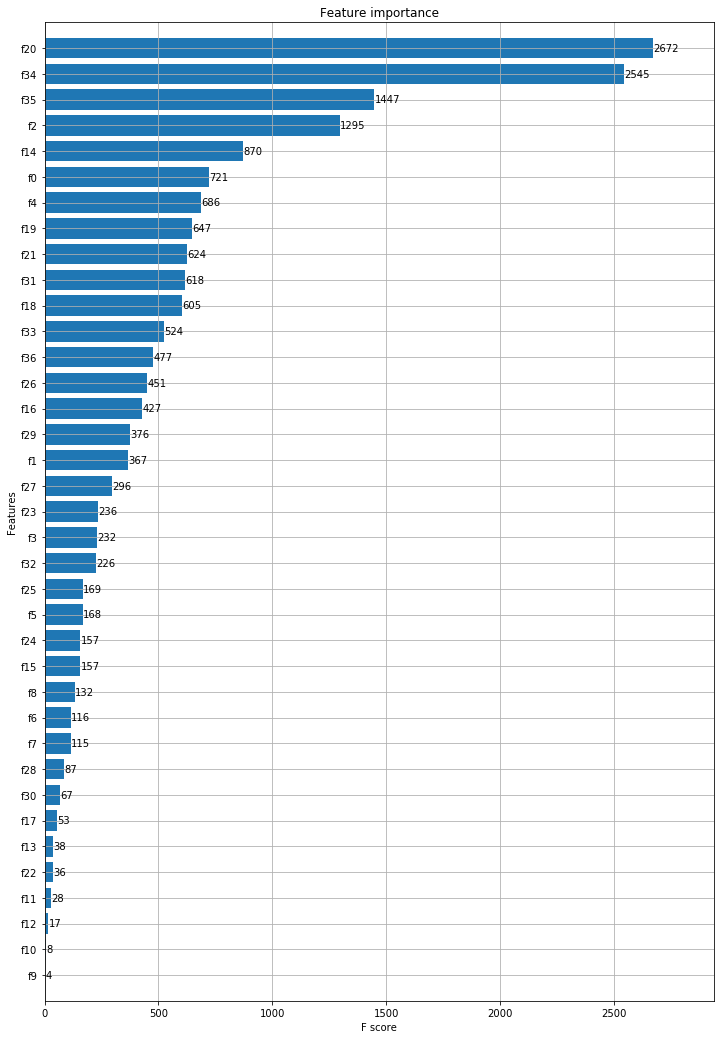

In [7]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
fig,ax=plt.subplots(figsize=(12,18))
xgb.plot_importance(xgb_model,height=0.8,ax=ax)
plt.show()


In [8]:
watchlist

[(<xgboost.core.DMatrix at 0x246af742f28>, 'train'),
 (<xgboost.core.DMatrix at 0x24680714828>, 'valid')]

In [ ]:
# lgb
params = {'metric': 'auc', 'learning_rate' : 0.01, 'max_depth':10, 'max_bin':10,  'objective': 'binary', 
          'feature_fraction': 0.8,'bagging_fraction':0.9,'bagging_freq':10,  'min_data': 500}

skf = StratifiedKFold(n_splits=kfold, random_state=1)
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(' lgb kfold: {}  of  {} : '.format(i+1, kfold))
    X_train, X_eval = X[train_index], X[test_index]
    y_train, y_eval = y[train_index], y[test_index]
    lgb_model = lgb.train(params, lgb.Dataset(X_train, label=y_train), nrounds, 
                  lgb.Dataset(X_eval, label=y_eval), verbose_eval=100, 
                  feval=gini_lgb, early_stopping_rounds=100)
    sub['target'] += lgb_model.predict(test[features].values, 
                        num_iteration=lgb_model.best_iteration) / (2*kfold)
    
sub.to_csv('sub11.csv', index=False, float_format='%.5f') 
gc.collect()
sub.head(2)
#sub.to_csv("C:\\Users\\hasee\\workspace\\Kaggle\\safe_driver\\train\\train.csv",index=True,float_format="%5f")

In [5]:
sub.to_csv("C:\\Users\\hasee\\workspace\\Kaggle\\safe_driver\\submission.csv",index=False,float_format="%5f")